In [43]:
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
files_csv = pd.read_csv("ATR_GT_Training.csv")


In [46]:
training_files = files_csv.dropna()
testing_files = files_csv[~files_csv.index.isin(training_files.index)]

In [47]:
testing_files.shape

(467, 2)

In [48]:
sub = {0.0: 0.0, 1.0: 1.0, 2.0: 1.0, 3.0: 1.0}
training_files['Label'] = training_files['Label'].map(sub)

In [49]:
colors = ['coral', 'mediumseagreen', 'mediumorchid', 'slateblue']


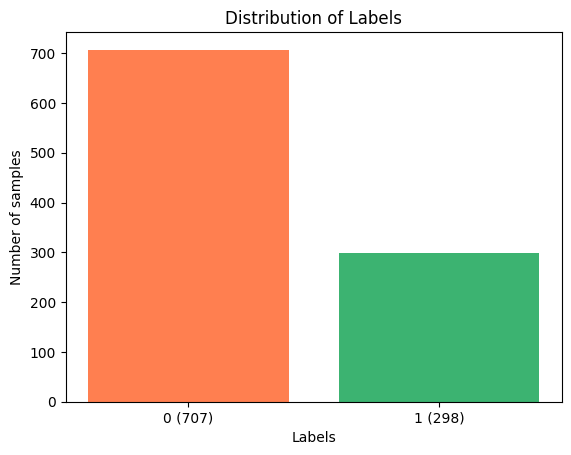

In [50]:
# Count the number of samples for each label
counts = [np.sum(np.array(training_files.iloc[:,1]) == i) for i in range(2)]

# Plot the histogram with labeled bars
plt.bar(range(2), counts, color=colors)
plt.xticks(range(2), [f'0 ({counts[0]})', f'1 ({counts[1]})'])
plt.xlabel('Labels')
plt.ylabel('Number of samples')
plt.title('Distribution of Labels')
plt.show()

In [51]:
images = []
for training_file in training_files.iloc[:,0]:
    nii_img = nib.load(f'./data/{training_file}.nii.gz')
    nii_data = nii_img.get_fdata()
    images.append(nii_data)

In [52]:
various_object_images=[0,2,6,57]

# 3D Data Visualization

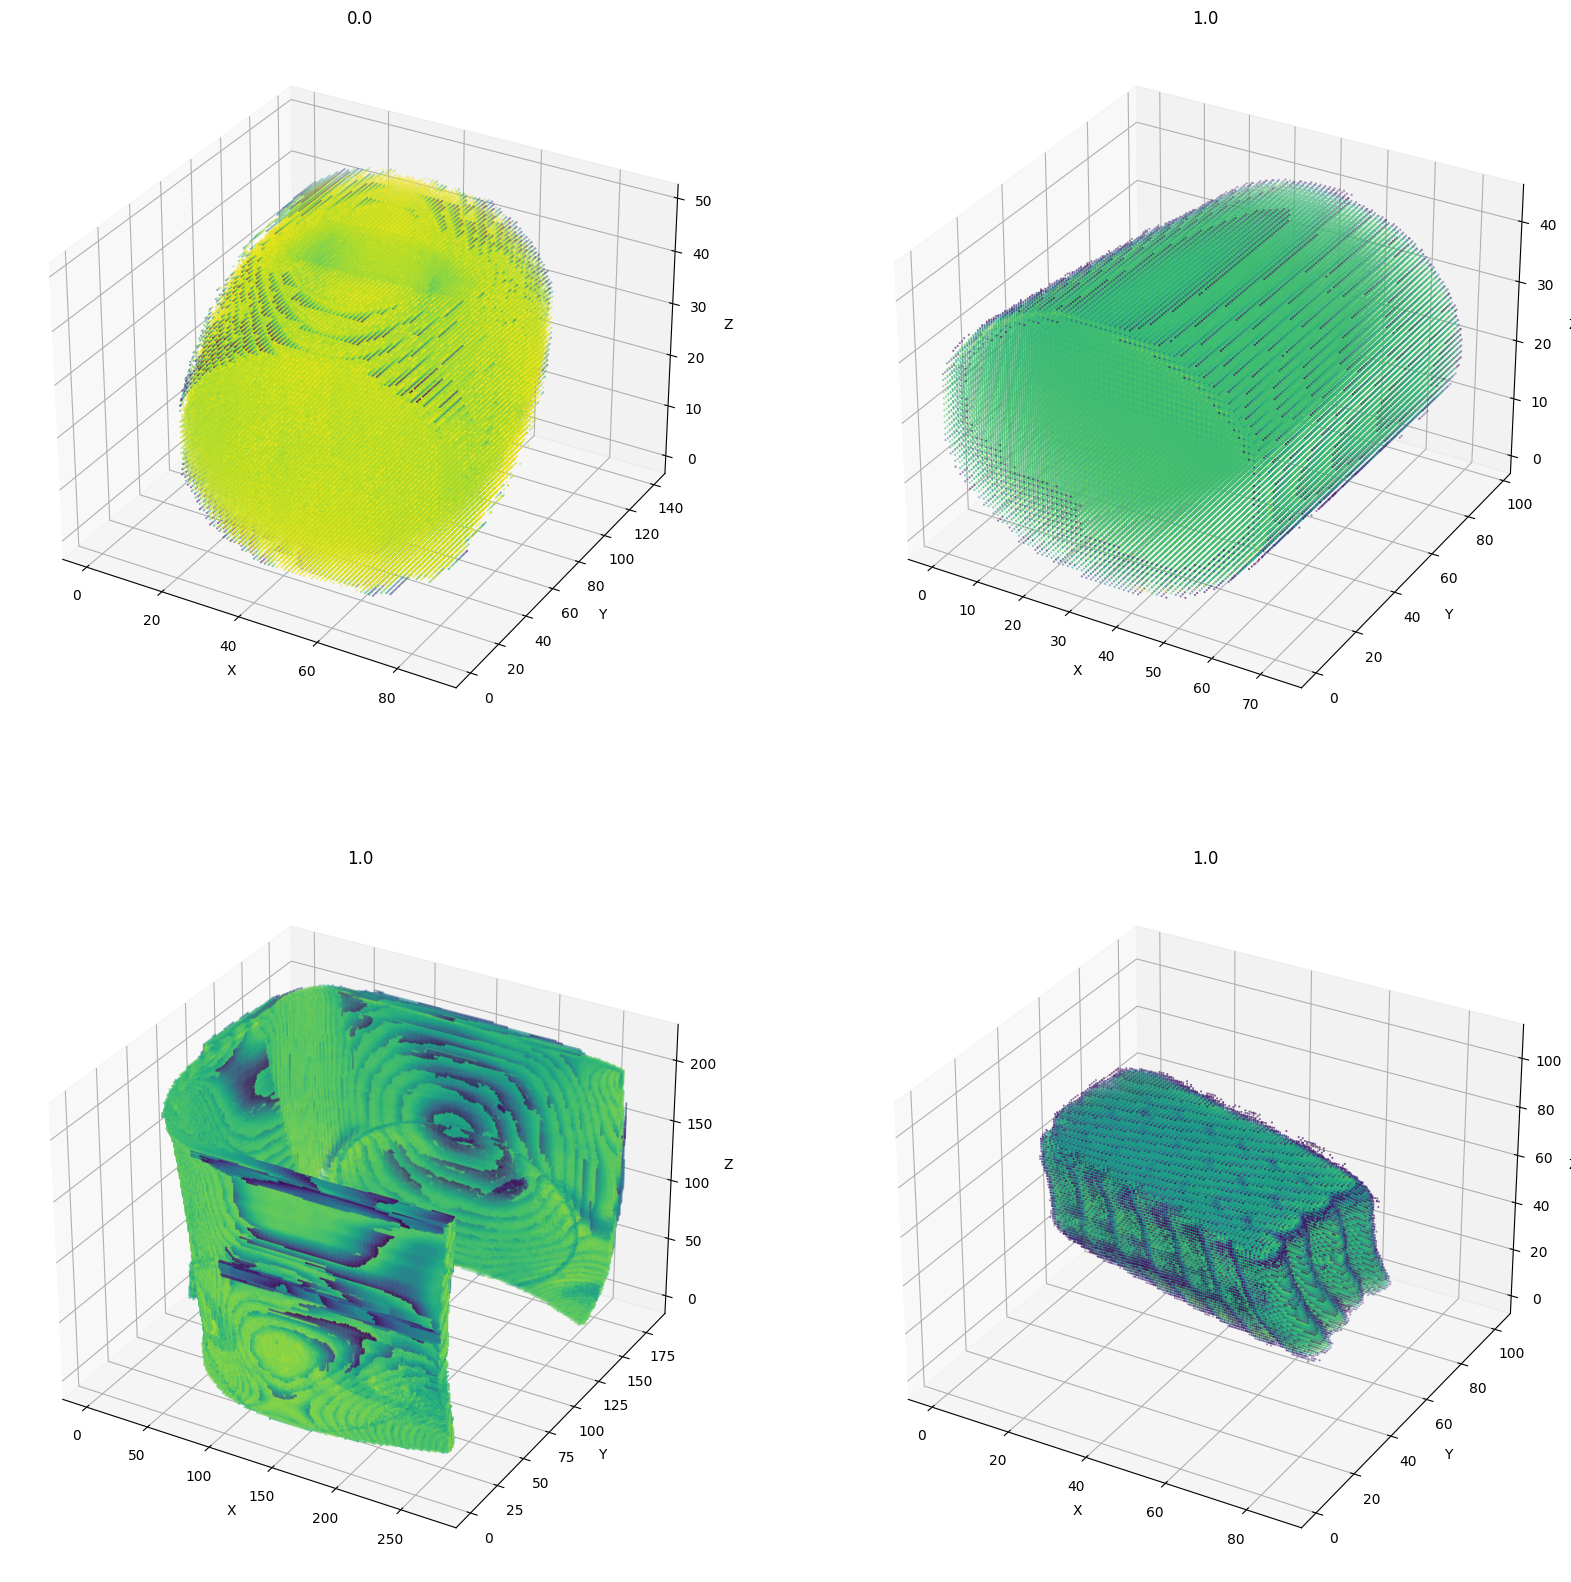

In [53]:
fig = plt.figure()
idx = 10

# for i in range(16):
def fun(i:int, idx:int)->None:
    ax = fig.add_subplot(2,2,idx,projection='3d')
    x,y,z = images[i].nonzero()
    ax.scatter(x, y, z, c=images[i][x, y, z], s=0.2)
    ax.set_title(str(training_files.iloc[i,1]))
    # Set the axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

various_object_images = [0,2,6,57]
for i in range(len(various_object_images)):
    fun(various_object_images[i],i+1)

plt.gcf().set_size_inches(20, 20)
# Show the plot
plt.show()

# Exploring Data

In [54]:
graph_bins = 100

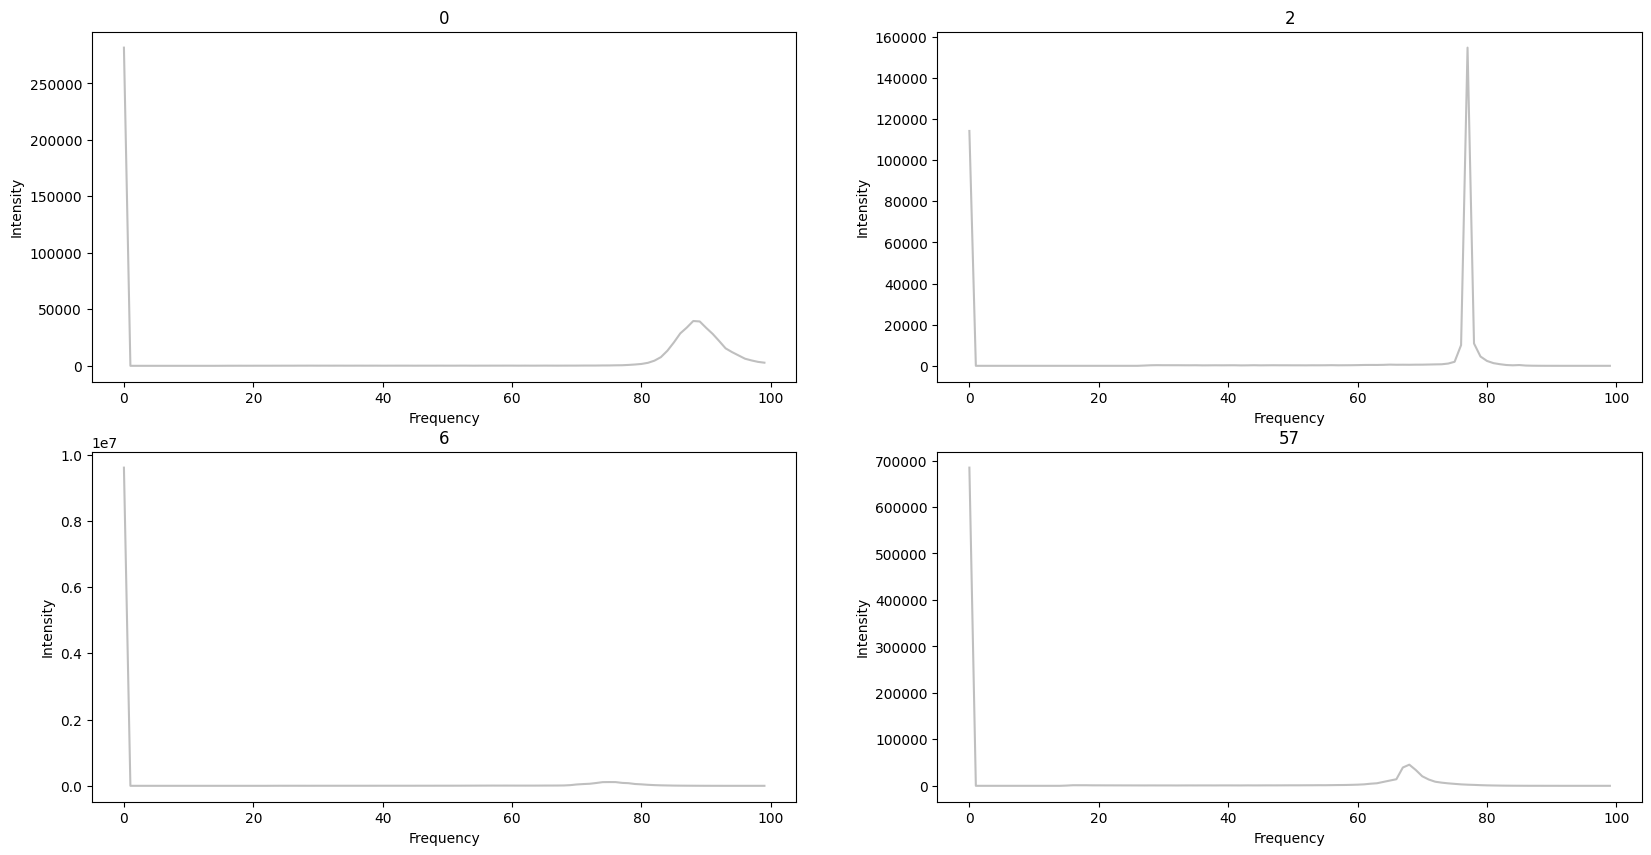

In [55]:
# Plot the histogram
fig = plt.figure()
for i in range(len(various_object_images)):
    flat = images[various_object_images[i]].flatten() 
    hist, _ = np.histogram(flat, bins=graph_bins) 
    ax = fig.add_subplot(2,2, i+1)
    ax.plot(hist, color='gray', alpha=0.5)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Intensity')
    ax.set_title(""+str(various_object_images[i]))

plt.gcf().set_size_inches(20, 10)
plt.show()


As you may have noticed that there're huge amount of intensity near zero which is just a background noise, so we will remove it.

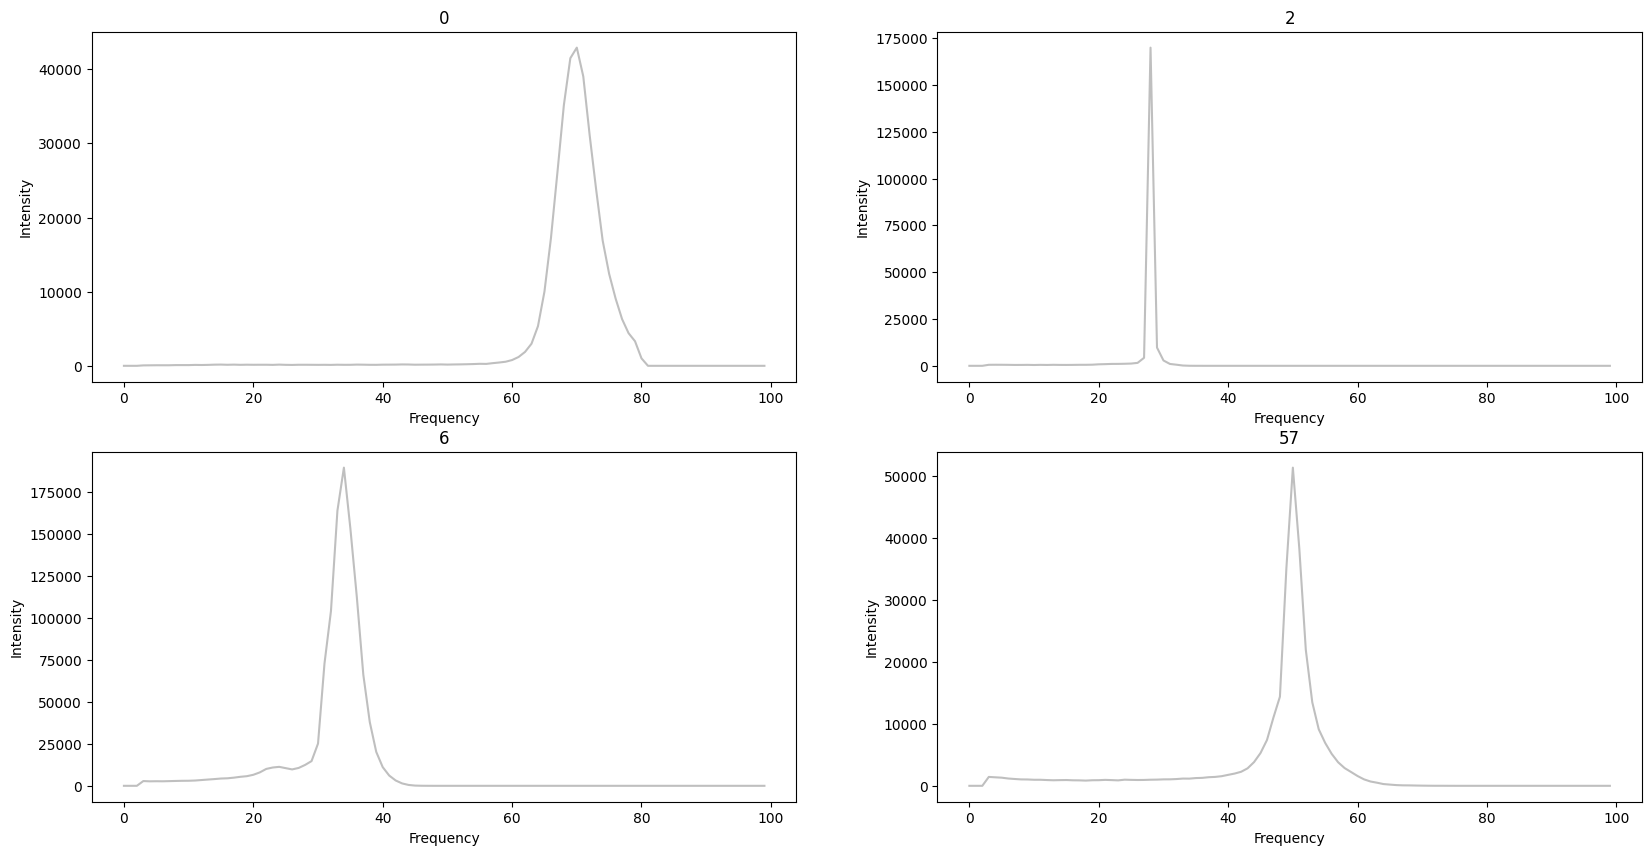

In [56]:
# Plot the histogram
fig = plt.figure()
for i in range(len(various_object_images)):
    flat = images[various_object_images[i]].flatten()
    hist, _ = np.histogram(flat, bins=graph_bins, range=(300, 3000)) 
    ax = fig.add_subplot(2,2, i+1)
    ax.plot(hist, color='gray', alpha=0.5)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Intensity')
    ax.set_title(""+str(various_object_images[i]))

plt.gcf().set_size_inches(20, 10)
plt.show()

After removing the noise, the graph looks much better; however, we can still do something better. We can normalize the intensity values to make the calculations easy for the later stages.

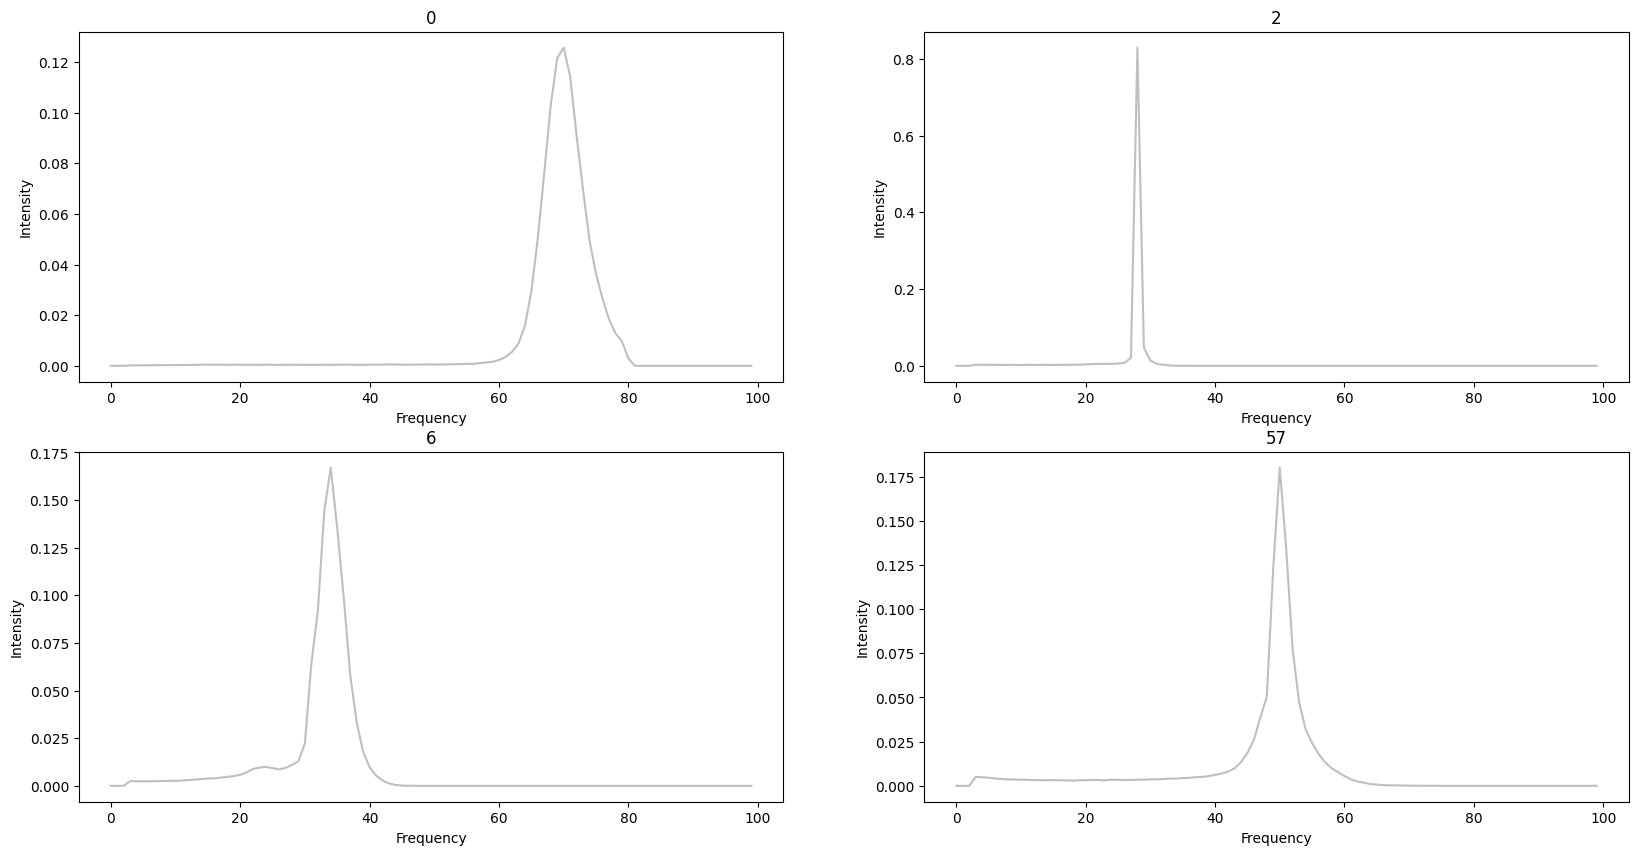

In [57]:
# Plot the histogram
fig = plt.figure()
for i in range(len(various_object_images)):
    flat = images[various_object_images[i]].flatten() 
    ax = fig.add_subplot(2,2, i+1)
    hist, _ = np.histogram(flat, bins=graph_bins, range=(300, 3000))
    ax.plot(hist/np.sum(hist), color='gray', alpha=0.5)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Intensity')
    ax.set_title(""+str(various_object_images[i]))

plt.gcf().set_size_inches(20, 10)
plt.show()

# Histogram Feature Extraction

In [58]:
hist_features = []
min_intensity, max_intensity = 300, 3000
bins = graph_bins

In [59]:
for img in images:
  hist, _ = np.histogram(img.flatten(), bins=bins, range=(min_intensity, max_intensity))
  hist_norm = hist / np.sum(hist)
  hist_features.append(hist_norm)

X = np.array(hist_features)

# Train Test Split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, training_files.iloc[:,1], test_size=0.2, random_state=42)

# Models

## SVM

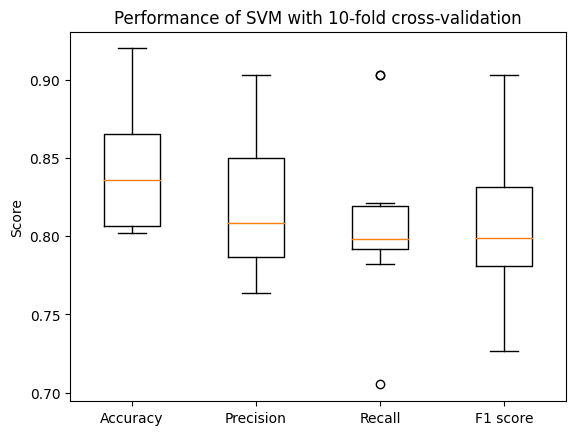

Test Accuracy=0.8428613861386138
Test Precision=0.8171128855873759
Test Recall=0.8108261060616572
Test F1 score=0.8096949586319037


In [61]:
# Create the classifier
svm = SVC(kernel='rbf', C=5, random_state=42)

# Define the metrics to be evaluated
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Perform 10-fold cross-validation and get the scores for each fold
cv_results = cross_validate(svm, X, training_files.iloc[:,1], cv=10, scoring=scoring)

# Create a dictionary to store the scores
score_dict_test = {'Accuracy': cv_results['test_accuracy'],
              'Precision': cv_results['test_precision_macro'],
              'Recall': cv_results['test_recall_macro'],
              'F1 score': cv_results['test_f1_macro']}

plt.boxplot(score_dict_test.values(), labels=score_dict_test.keys())
plt.ylabel('Score')
plt.title('Performance of SVM with 10-fold cross-validation')
plt.show()
for k, v in score_dict_test.items():
    print(f"Test {k}={np.mean(v)}")

## SVM with PCA

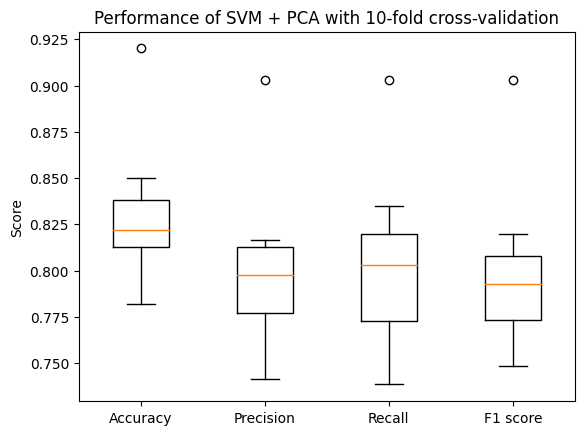

Test Accuracy=0.829940594059406
Test Precision=0.8007091927790494
Test Recall=0.8026307268900761
Test F1 score=0.7979906734632481


In [62]:
# Create the PCA
pca = PCA(n_components=20, random_state=42)

X_train_pca = pca.fit_transform(X)
# X_test_pca = pca.transform(X_test)
# Create the classifier
svm = SVC(kernel='rbf', C=7, random_state=42)

# Define the metrics to be evaluated
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
# Perform 10-fold cross-validation and get the scores for each fold
cv_results = cross_validate(svm, X_train_pca, training_files.iloc[:,1], cv=10, scoring=scoring)

# Create a dictionary to store the scores
score_dict_test = {'Accuracy': cv_results['test_accuracy'],
              'Precision': cv_results['test_precision_macro'],
              'Recall': cv_results['test_recall_macro'],
              'F1 score': cv_results['test_f1_macro']}

plt.boxplot(score_dict_test.values(), labels=score_dict_test.keys())
plt.ylabel('Score')
plt.title('Performance of SVM + PCA with 10-fold cross-validation')
plt.show()
for k, v in score_dict_test.items():
    print(f"Test {k}={np.mean(v)}")

## KNN

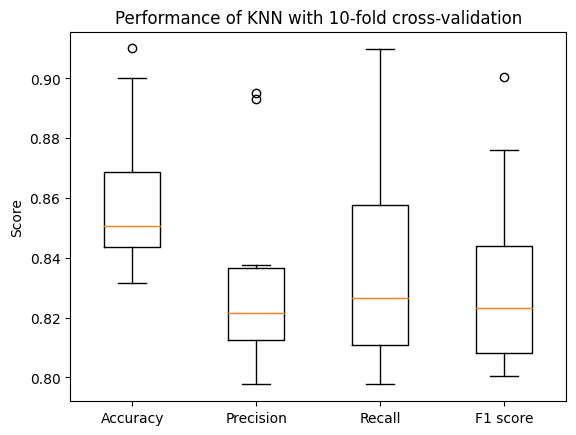

Test Accuracy=0.8607425742574257
Test Precision=0.8330013628971173
Test Recall=0.8357661790033845
Test F1 score=0.8332968067255129


In [63]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='uniform')
# Define the metrics to be evaluated
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
# Define the K-fold cross-validation object
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform 10-fold cross-validation and get the scores for each fold
cv_results = cross_validate(knn, X, training_files.iloc[:,1], cv=kfold, scoring=scoring)

# Create a dictionary to store the scores
score_dict_test = {'Accuracy': cv_results['test_accuracy'],
              'Precision': cv_results['test_precision_macro'],
              'Recall': cv_results['test_recall_macro'],
              'F1 score': cv_results['test_f1_macro']}

plt.boxplot(score_dict_test.values(), labels=score_dict_test.keys())
plt.ylabel('Score')
plt.title('Performance of KNN with 10-fold cross-validation')
plt.show()
for k, v in score_dict_test.items():
    print(f"Test {k}={np.mean(v)}")


## Logistic Regression

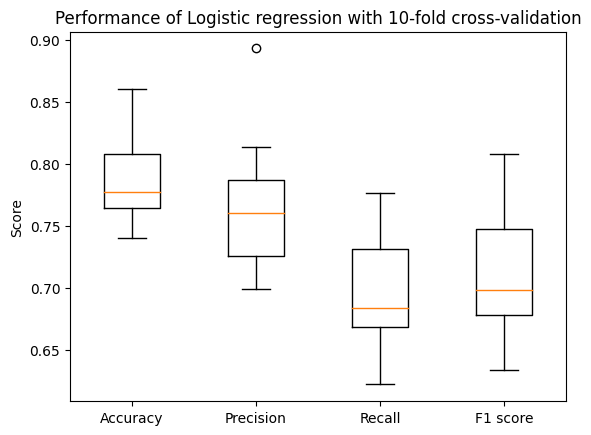

Test Accuracy=0.788059405940594
Test Precision=0.7666729102315932
Test Recall=0.6948425553459661
Test F1 score=0.7108268693198768


In [64]:
lr = LogisticRegression(C=1, solver='sag', penalty='l2', random_state=42, max_iter=3000)
# Define the metrics to be evaluated
# scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scoring = {'accuracy': 'accuracy', 
           'precision_macro': make_scorer(precision_score, average='macro', zero_division=1),
           'recall_macro': make_scorer(recall_score, average='macro'),
           'f1_macro': make_scorer(f1_score, average='macro'),
           }
# Define the K-fold cross-validation object
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform 10-fold cross-validation and get the scores for each fold
cv_results = cross_validate(lr, X, training_files.iloc[:,1], cv=kfold, scoring=scoring)

# Create a dictionary to store the scores
score_dict_test = {'Accuracy': cv_results['test_accuracy'],
              'Precision': cv_results['test_precision_macro'],
              'Recall': cv_results['test_recall_macro'],
              'F1 score': cv_results['test_f1_macro']}

plt.boxplot(score_dict_test.values(), labels=score_dict_test.keys())
plt.ylabel('Score')
plt.title('Performance of Logistic regression with 10-fold cross-validation')
plt.show()
for k, v in score_dict_test.items():
    print(f"Test {k}={np.mean(v)}")

## Decision Tree with AdaBoost

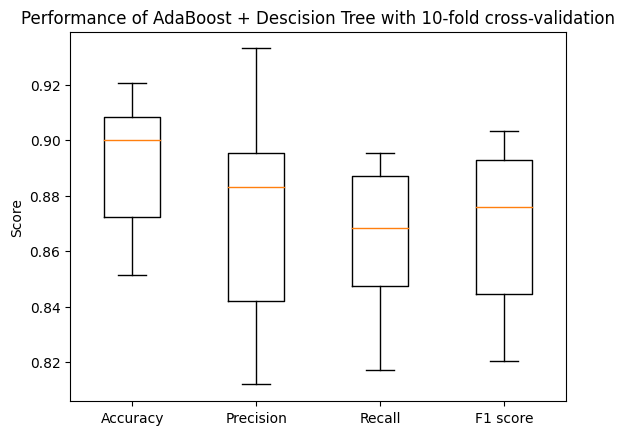

Test Accuracy=0.8905643564356437
Test Precision=0.8726882538050852
Test Recall=0.8644015051566196
Test F1 score=0.8675444329798314


In [65]:
dtc = DecisionTreeClassifier(max_depth=7, criterion='gini', min_samples_split=4, random_state=42)
abc = AdaBoostClassifier(estimator=dtc, n_estimators=100, random_state=42)
# Define the metrics to be evaluated
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
# Define the K-fold cross-validation object
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform 10-fold cross-validation and get the scores for each fold
cv_results = cross_validate(abc, X, training_files.iloc[:,1], cv=kfold, scoring=scoring)

# Create a dictionary to store the scores
score_dict_test = {'Accuracy': cv_results['test_accuracy'],
              'Precision': cv_results['test_precision_macro'],
              'Recall': cv_results['test_recall_macro'],
              'F1 score': cv_results['test_f1_macro']}

plt.boxplot(score_dict_test.values(), labels=score_dict_test.keys())
plt.ylabel('Score')
plt.title('Performance of AdaBoost + Descision Tree with 10-fold cross-validation')
plt.show()
for k, v in score_dict_test.items():
    print(f"Test {k}={np.mean(v)}")


# Extra

In [66]:
clf = svm = SVC(kernel='rbf', C=5, random_state=42)

# Fit the pipeline to the training data
clf.fit(X_train,y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy: 0.835820895522388
Precision: 0.8042087542087542
Recall: 0.8173887587822014
F1 Score: 0.8100787401574803


In [67]:
clf = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='uniform')

# Fit the pipeline to the training data
clf.fit(X_train,y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.8606965174129353
Precision: 0.8316864295125164
Recall: 0.8537470725995316
F1 Score: 0.8408371040723981


In [68]:
clf = LogisticRegression(C=1, solver='sag', penalty='l2', random_state=42, max_iter=3000)

# Fit the pipeline to the training data
clf.fit(X_train,y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.7960199004975125
Precision: 0.788888888888889
Recall: 0.7009367681498829
F1 Score: 0.7214466790603347


In [69]:
dtc = DecisionTreeClassifier(max_depth=7, criterion='gini', min_samples_split=4, random_state=42)
abc = AdaBoostClassifier(estimator=dtc, n_estimators=100, random_state=42)

# Fit the model to the training data
abc.fit(X_train, y_train)

# Predict on the test data
y_pred = abc.predict(X_test)

# Evaluate the classifier on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9054726368159204
Precision: 0.886980737990253
Recall: 0.8905152224824355
F1 Score: 0.8887140484308069
